1. LOAD & PROCESS DATA

Explanation:

- The loop iterates through the folders and loads each image.
- The images are resized to 150x150 pixels, as CNNs require images of fixed size.
- We convert the image data and labels into NumPy arrays for easier manipulation.

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for progress bar

# Paths to your data
data_dir = "/kaggle/input/lung-cancer-types/PROJET_CHOPPER_0/lung_cancer_data"

# Define categories (adenocarcinoma, benign, squamous cell carcinoma)
categories = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

# Lists to hold data and labels
data = []
labels = []

# Loop through categories and images
for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)  # Assign a label index to each category
    for img_name in tqdm(os.listdir(path), desc=f"Loading {category} images"):  # Progress bar for each category
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)      # Read the image
            img = cv2.resize(img, (150, 150))  # Resize to 150x150 pixels
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Loading squamous_cell_carcinoma images: 100%|██████████| 5000/5000 [01:12<00:00, 68.88it/s]


X_train shape: (12000, 150, 150, 3), y_train shape: (12000,)
X_test shape: (3000, 150, 150, 3), y_test shape: (3000,)


2. IMAGE AUGMENTATION

Explanation:

- ImageDataGenerator helps to augment images on the fly, creating slight variations to make the model more robust.
- To check it we visualize some sample

In [5]:
# Before passing to the generator, make sure labels are one-hot encoded and reshaped correctly
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Checking Train shape before Augmenting
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (12000, 150, 150, 3)
y_train shape: (12000, 3)


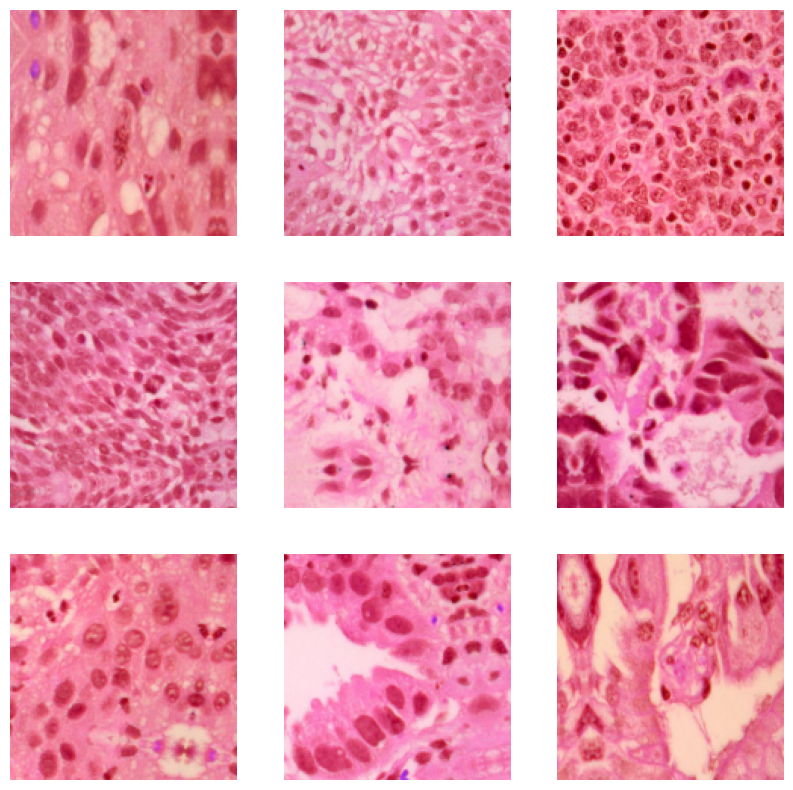

(12000, 3)
(3000, 3)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.09,
    zoom_range=0.09,
    horizontal_flip=True,
    fill_mode='reflect', 
    
)

# Generate augmented data
train_gen = datagen.flow(X_train, y_train, batch_size=32)

# Get a batch of images and labels from the generator
X_batch, y_batch = next(train_gen)

# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_batch[i])
    plt.axis('off')  # Hide the axes for a cleaner visualization

plt.show()

print(y_train.shape)
print(y_test.shape)



3. Building a CNN Model

Explanation:

- Three convolutional layers with ReLU activation extract features from images.
- MaxPooling2D reduces the dimensionality of the feature maps, making the model computationally efficient.
- A fully connected layer with 128 neurons followed by a dropout layer to prevent overfitting.
- The last layer uses softmax to output probabilities for each class (adenocarcinoma, benign).

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3), 
                 kernel_regularizer=l2(0.03)))  # L2 regularization
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', 
                 kernel_regularizer=l2(0.03)))  # L2 regularization
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu',
         kernel_regularizer=l2(0.03)))  # L2 regularization
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layer
model.add(Flatten())
model.add(Dense(64, activation='relu',
         kernel_regularizer=l2(0.03)))  # L2 regularization

model.add(Dropout(0.7))
model.add(Dense(3, activation='softmax'))  # 3 classes (adenocarcinoma, benign, squamish)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,207,587 (4.61 MB)

 Trainable params: 1,207,587 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

4. Training the Model

PS : The model is trained for 5 epochs as it tends to overfit real quick

In [ ]:
# Training model
history = model.fit(train_gen, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 151s 393ms/step - accuracy: 0.6236 - loss: 4.1258 - val_accuracy: 0.8153 - val_loss: 30.9559
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 392ms/step - accuracy: 0.7824 - loss: 1.4307 - val_accuracy: 0.7827 - val_loss: 45.4581
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 392ms/step - accuracy: 0.8116 - loss: 1.0377 - val_accuracy: 0.8457 - val_loss: 35.2856
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 147s 388ms/step - accuracy: 0.8244 - loss: 0.8937 - val_accuracy: 0.8667 - val_loss: 27.0446
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 384ms/step - accuracy: 0.8368 - loss: 0.8166 - val_accuracy: 0.8023 - val_loss: 50.4320
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 382ms/step - accuracy: 0.8494 - loss: 0.7667 - val_accuracy: 0.8490 - val_loss: 33.2768
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 146s 385ms/step - accuracy: 0.8484 - loss: 0.7437 - val_accuracy: 0.8337 - val_loss: 40.0905
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 384ms/step - accuracy: 0